In [41]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Modelling")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [42]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np
from itertools import combinations



In [43]:
yellow_sdf = spark.read.parquet('../data/curated/yellow_tlc_final/')

Find the besat features for a linear model using sk leanr'

In [44]:
'''sample the data into a andas dataframe to se for stepwise featuire selection as we will use 
sklearn linear regression for it as spark ML will take too much compuation power to run'''

yellow_df = yellow_sdf.sample(0.005, seed = 8).toPandas()

/home/wconlon28/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/wconlon28/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [46]:
#crerate a features data frame with the features we want to trial in stepwise selection
features_df = yellow_df[["trip_distance", 'trip_time_min', "day_of_week", "passenger_count", "airport_fee", \
                                        'congestion_surcharge', 'tolls_amount', 'payment_type',\
                                          'is_weekend', 'morning_0_to_6', 'morning_6_to_10', 'evening_17_to_20']].copy()

#we will put the predicted variable in its own responce dataframe
responce_df  = yellow_df['fare_amount']

In [47]:
#split the data into a train sset and a test set
features_train, features_test, responce_train, responce_test = train_test_split(features_df, responce_df, train_size = 0.8)

In [8]:
def stepwise_BIC (X_train, y_train, X_test, y_test):
    """This function calculates the BIC for every possible combination of features' model and 
    then returns features that achieved the lowest BIC of all combinations as well as that BIC value"""
    
    n, f = X_train.shape

    best_bic = float('inf')
    best_features = [] 

    
    for num_features in range(1, f+1):
        for features in combinations(X_train.columns, num_features):
            current_features = X_train[list(features)]

            model = LinearRegression()
            model.fit(current_features, y_train)

            y_pred = model.predict(X_test[list(current_features)])
            residuals = y_test-y_pred

            rss = np.sum(residuals**2)
            bic = n*np.log(rss/n)+num_features*np.log(n)

            if bic<best_bic:
                best_bic = bic
                best_features = list(features)
    
    return best_bic, best_features

In [48]:
#Run stepwise selection on our features to find the best combination
model_bic, model_features = stepwise_BIC(features_train, responce_train, features_test, responce_test)

#Our selcted features we will use fr our model are:
model_features

['trip_distance',
 'trip_time_min',
 'day_of_week',
 'airport_fee',
 'tolls_amount',
 'is_weekend',
 'morning_0_to_6',
 'morning_6_to_10']

Making our Test and Train feature vectors for our Regression Models

In [49]:
features = 'features'

assembler = VectorAssembler(
    # which column to combine
    inputCols=model_features, 
    # How should the combined columns be named
    outputCol=features
)

model_sdf = assembler.transform(yellow_sdf)


In [50]:
#Split our data into train and test dataframes
splits_sdf = model_sdf.randomSplit([0.8, 0.2], seed = 8)

train_sdf= splits_sdf[0]
test_sdf=splits_sdf[1]


Linear Regression

In [51]:
#Since we used Sklearn LinearRegression above we most ensure that we now are using Pyspark.ML Linear Regression
from pyspark.ml.regression import LinearRegression

#fit our training data
lin_reg = LinearRegression(featuresCol = 'features', labelCol='fare_amount')
linear_model = lin_reg.fit(train_sdf)

23/08/19 21:39:51 WARN Instrumentation: [fca45b33] regParam is zero, which might cause numerical instability and overfitting.


In [52]:
#Print our used features and their corresponding coefficiciants
pd.DataFrame(
    data=[linear_model.intercept] + list(linear_model.coefficients),
    index=['intercept'] + model_features,
    columns=['coefficient']
)

,coefficient
intercept,4.747672
trip_distance,2.819181
trip_time_min,0.006869
day_of_week,0.095114
airport_fee,-1.491119
tolls_amount,-0.111559
is_weekend,-0.534758
morning_0_to_6,-1.430232
morning_6_to_10,-0.636239


In [53]:
#Evaluate how the model did using R^2 and RMSE
test_result = linear_model.evaluate(test_sdf)

print("Root Mean Squared Error (RMSE) on test data = ", test_result.rootMeanSquaredError)
print("Coefficiant of Determination (R^2) on test data = ", test_result.r2)

Root Mean Squared Error (RMSE) on test data =  2.9113103569011014
Coefficiant of Determination (R^2) on test data =  0.8944090176485434


Random Tree Regression

In [54]:
#Fit the Random Forest Model to my trainging data
rf_reg = RandomForestRegressor(featuresCol = 'features', labelCol='fare_amount')
rf_model = rf_reg.fit(train_sdf)

23/08/19 21:48:48 WARN MemoryStore: Not enough space to cache rdd_132_7 in memory! (computed 29.6 MiB so far)
23/08/19 21:48:48 WARN BlockManager: Persisting block rdd_132_7 to disk instead.
23/08/19 21:48:48 WARN MemoryStore: Not enough space to cache rdd_132_3 in memory! (computed 29.6 MiB so far)
23/08/19 21:48:48 WARN BlockManager: Persisting block rdd_132_3 to disk instead.
23/08/19 21:48:48 WARN MemoryStore: Not enough space to cache rdd_132_5 in memory! (computed 19.2 MiB so far)
23/08/19 21:48:48 WARN BlockManager: Persisting block rdd_132_5 to disk instead.
23/08/19 21:48:48 WARN MemoryStore: Not enough space to cache rdd_132_4 in memory! (computed 44.4 MiB so far)
23/08/19 21:48:48 WARN BlockManager: Persisting block rdd_132_4 to disk instead.
23/08/19 21:48:49 WARN MemoryStore: Not enough space to cache rdd_132_1 in memory! (computed 44.4 MiB so far)
23/08/19 21:48:49 WARN BlockManager: Persisting block rdd_132_1 to disk instead.
23/08/19 21:48:49 WARN MemoryStore: Not enoug

In [55]:
#Predict how the model did with the test data
predictions = rf_model.transform(test_sdf)

#Evaluate the RFR model based on the predictions and calculate the R^2 and RMSE for the model
evaluation = RegressionEvaluator(labelCol='fare_amount', predictionCol="prediction", metricName='rmse')
rsme_rf = evaluation.evaluate(predictions)

evaluation = RegressionEvaluator(labelCol='fare_amount', predictionCol="prediction", metricName='r2')
r2_rf = evaluation.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = ", rsme_rf)
print("Coefficiant of Determination (R^2) on test data = ", r2_rf)

Root Mean Squared Error (RMSE) on test data =  2.2451472040220777
Coefficiant of Determination (R^2) on test data =  0.937202918330807


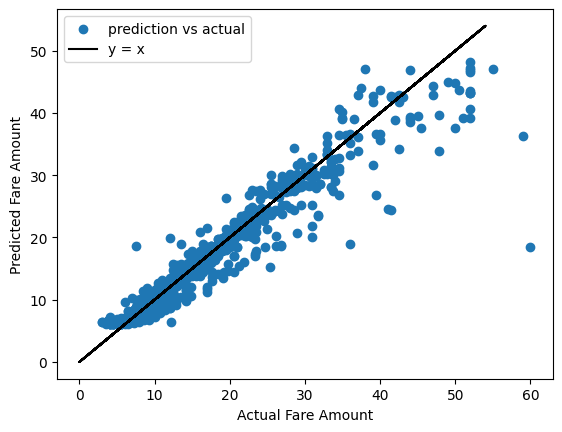

In [57]:
#Take a sample of the predictions to use for plotting for visualisation purposes
pred_actual = predictions.select(F.col('prediction'), F.col('fare_amount')).sample(0.0005, seed = 8).toPandas()

#Take 100 random points between 0 and 55 to plot a diagonal on the graph to see how closely rfr's predictions are to our actual data
x = np.random.randint(0, 55, 100)

plt.scatter(pred_actual['fare_amount'], pred_actual['prediction'])
plt.plot(x, x, c = 'k')
plt.legend(['prediction vs actual', 'y = x'], loc = 2, prop = {'size':10})
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.savefig("/home/wconlon28/mast30034-project-1-Wconlon28-4/plots/RFR_Results")